In [1]:
# Import all the required libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import InputLayer, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose
import matplotlib.pyplot as plt

In [2]:
# Parameters
img_height, img_width, img_channel = 28, 28, 1
n_batch = 128
n_epoch = 100
latent_dim = 2

In [3]:
# Import dataset MNIST-Fashion dataset
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()
mnist = np.concatenate([x_train, x_test], axis=0)
mnist = np.expand_dims(mnist, -1).astype("float32") / 255

In [4]:
# Define the VAE as a Model with a custom train_step
class VAE(keras.Model):
    def __init__(self, **kwargs):
        super(VAE, self).__init__(**kwargs)
        
        # encoder
        self.encoder = tf.keras.Sequential([
            InputLayer(input_shape=(img_height, img_width, img_channel)),
            Conv2D(32, 3, activation="relu", strides=2, padding="same"),
            Conv2D(64, 3, activation="relu", strides=2, padding="same"),
            Flatten(),
            Dense(16, activation="relu"),
            Dense(latent_dim),
        ])
        
        # reparameterization/sampling layer 
        self.z_mean = Dense(latent_dim, name="z_mean")
        self.z_log_var = Dense(latent_dim, name="z_log_var")
        
        # decoder
        self.decoder = tf.keras.Sequential([
            InputLayer(input_shape=(latent_dim,)),
            Dense(7 * 7 * 64, activation="relu"),
            Reshape((7, 7, 64)),
            Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same"),
            Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same"),
            Conv2DTranspose(1, 3, activation="sigmoid", padding="same"),
        ])
        
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        
     
    # Build the encoder
    def encode(self, data):
        x = self.encoder(data)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        return z_mean, z_log_var
    
    # Build the reparameterization/sampling layer 
    def reparameterization(self, z_mean, z_log_var):
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        z =  z_mean + tf.exp(0.5 * z_log_var) * epsilon
        return z
    
    # Build the decoder
    def decode(self, data):
        return self.decoder(data)
        
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encode(data)
            z = self.reparameterization(z_mean, z_log_var)      
            reconstruction = self.decode(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [5]:
# Train the VAE
vae = VAE()
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist, epochs= n_epoch, batch_size= n_batch)

Epoch 1/100
547/547 [==============================] - 8s 11ms/step - loss: 389.8717 - reconstruction_loss: 343.9093 - kl_loss: 5.4647
Epoch 2/100
547/547 [==============================] - 5s 10ms/step - loss: 296.3927 - reconstruction_loss: 281.6868 - kl_loss: 8.1389
Epoch 3/100
547/547 [==============================] - 6s 11ms/step - loss: 278.9699 - reconstruction_loss: 270.3970 - kl_loss: 7.5400
Epoch 4/100
547/547 [==============================] - 6s 12ms/step - loss: 274.5002 - reconstruction_loss: 266.5602 - kl_loss: 7.2377
Epoch 5/100
547/547 [==============================] - 6s 11ms/step - loss: 272.1114 - reconstruction_loss: 264.4515 - kl_loss: 7.0952
Epoch 6/100
547/547 [==============================] - 6s 11ms/step - loss: 270.0005 - reconstruction_loss: 262.7828 - kl_loss: 7.0253
Epoch 7/100
547/547 [==============================] - 5s 10ms/step - loss: 269.3160 - reconstruction_loss: 261.8829 - kl_loss: 6.9774
Epoch 8/100
547/547 [==============================] - 

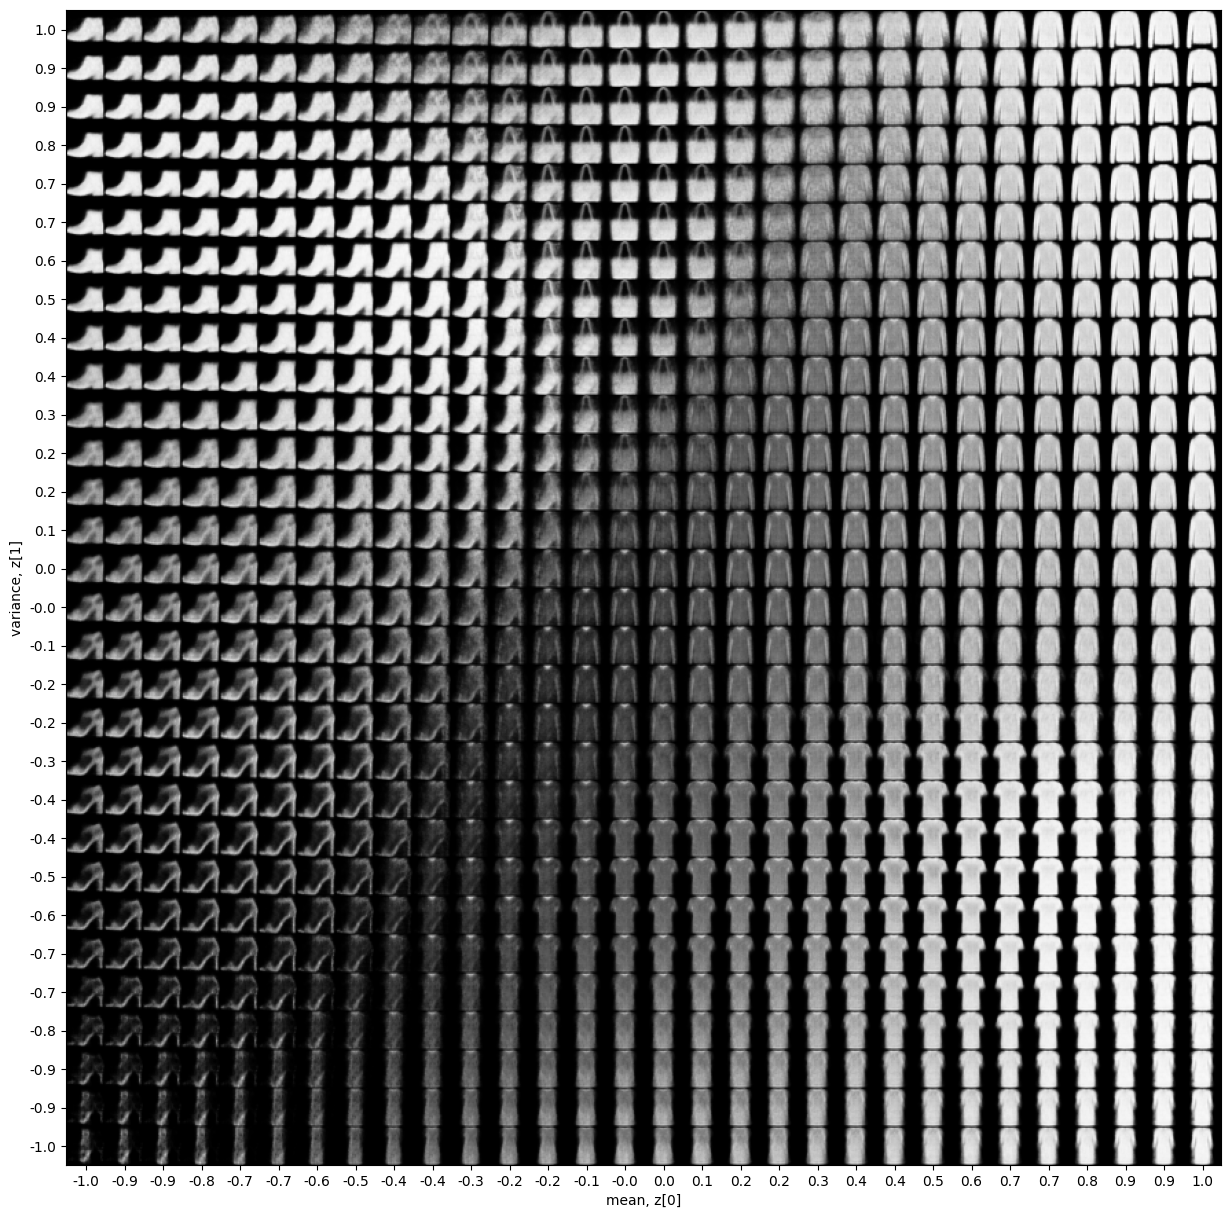

In [6]:
# Display a grid of sampled classes
def plot_latent_space(vae, n=30, figsize=15):
    img_height = 28
    scale = 1.0
    figure = np.zeros((img_height * n, img_height * n))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            classes = x_decoded[0].reshape(img_height, img_height)
            figure[
                i * img_height : (i + 1) * img_height,
                j * img_height : (j + 1) * img_height,
            ] = classes

    plt.figure(figsize=(figsize, figsize))
    start_range = img_height // 2
    end_range = n * img_height + start_range
    pixel_range = np.arange(start_range, end_range, img_height)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z[0]")
    plt.ylabel("variance, z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent_space(vae)

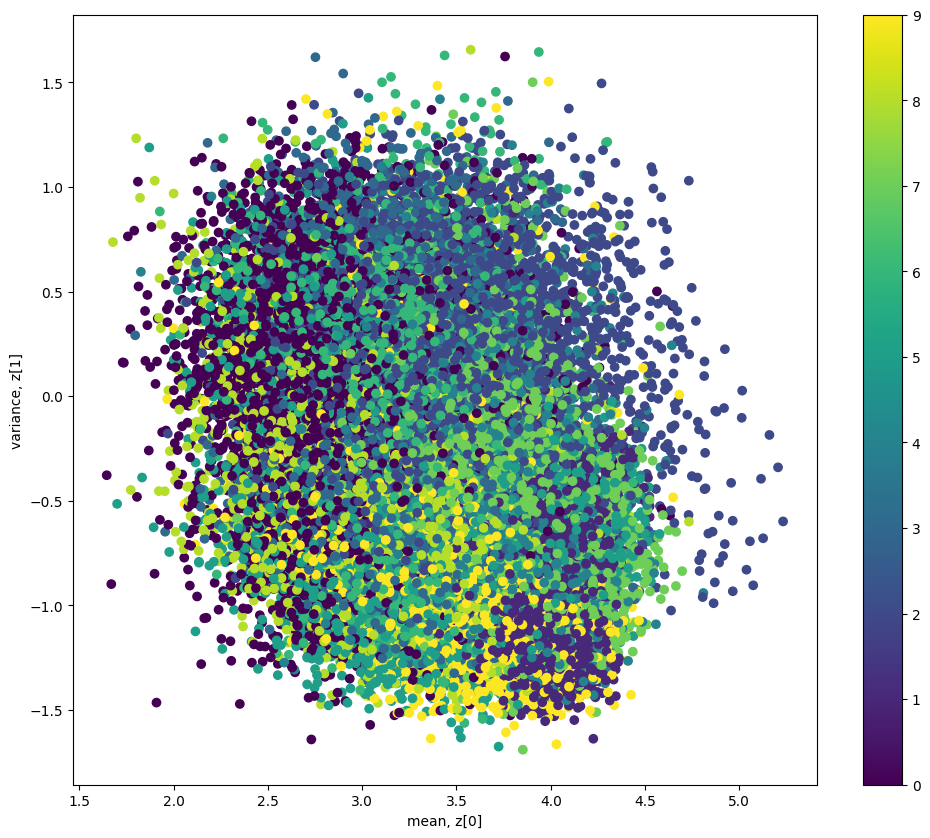

In [7]:
# Display how the latent space clusters different data classes 
def plot_label_clusters(vae, data, labels):
    z_mean= vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("mean, z[0]")
    plt.ylabel("variance, z[1]")
    plt.show()

(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)